In [1]:
import os
import duckdb
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

%load_ext sql

from dotenv import load_dotenv

load_dotenv()

DB_PATH = Path(".").absolute().parent / Path(os.getenv("SILVER_DUCKDB_PATH", ""))

TMP_DIR = "/tmp/duckdb_tmp"  # make sure it exists

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

conn = duckdb.connect(DB_PATH)

conn.execute(f"SET temp_directory='{TMP_DIR}'")
conn.execute("SET memory_limit='50GB'")
conn.execute("SET threads=1")
conn.execute("SET preserve_insertion_order=false")

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (6, 4)

%sql conn --alias duck

Tip: You may define configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml or /home/c-cc2016/ra173608/.jupysql/config.

Did not find user configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml.

In [3]:
%%sql
SELECT * FROM autoria_iniciativa_senado LIMIT 5;

Running query in 'duck'

id_autoria_iniciativa,id_processo,codigo_parlamentar,descricao_tipo,ente,ordem,outros_autores_nao_informados,sigla_ente,sigla_tipo,year_snapshot
1,2526458,None,PRESIDENTE_REPUBLICA,Presidência da República,1,Não,PR,PRESIDENTE_REPUBLICA,2001
2,663587,825,SENADOR,Senado Federal,1,Não,SF,SENADOR,2005
3,1066060,None,COMISSAO_CAMARA,"Comissão de Ciência e Tecnologia, Comunicação e Informática",1,Não,CCTCI,COMISSAO_CAMARA,2007
4,2978567,825,SENADOR,Senado Federal,1,Não,SF,SENADOR,2007
5,2968939,825,SENADOR,Senado Federal,1,Não,SF,SENADOR,2008


In [7]:
%%sql
DROP VIEW IF EXISTS autoria_iniciativa_senado_norm;

CREATE VIEW autoria_iniciativa_senado_norm AS
WITH base AS (
  SELECT
    id_autoria_iniciativa,
    id_processo,
    descricao_tipo,
    ente,
    ordem,
    outros_autores_nao_informados,
    UPPER(NULLIF(TRIM(sigla_ente), ''))  AS sigla_ente_norm,
    UPPER(NULLIF(TRIM(sigla_tipo), ''))  AS sigla_tipo_norm,
    TRY_CAST(codigo_parlamentar AS BIGINT) AS codigo_parlamentar_num,
    year_snapshot
  FROM autoria_iniciativa_senado
),
typed AS (
  SELECT
    b.*,

    CASE
      WHEN COALESCE(outros_autores_nao_informados, '') ILIKE 'Sim'
        THEN 'nao_informado'
      WHEN codigo_parlamentar_num IS NOT NULL
        THEN 'parlamentar'
      ELSE 'ente'
    END AS author_type,

    /* Decide the chamber for parlamentares */
    CASE
      WHEN codigo_parlamentar_num IS NULL
        THEN NULL
      WHEN UPPER(TRIM(descricao_tipo)) = 'SENADOR'
        THEN 'S'
      WHEN UPPER(TRIM(descricao_tipo)) IN ('DEPUTADO','DEPUTADA')
        THEN 'D'
      WHEN sigla_ente_norm = 'SF'
        THEN 'S'
      WHEN sigla_ente_norm = 'CD'
        THEN 'D'
      ELSE 'S'  -- fallback (tweak if you want to bias to D)
    END AS parl_chamber,

    /* Effective ente sigla for non-parlamentares */
    COALESCE(sigla_ente_norm, sigla_tipo_norm) AS ente_sigla_effective
  FROM base b
)
SELECT
  id_autoria_iniciativa,
  id_processo,

  /* 'parlamentar' | 'ente' | 'nao_informado' */
  author_type,

  /* For convenience: 'senador' | 'deputado' | NULL */
  CASE
    WHEN author_type = 'parlamentar' AND parl_chamber = 'S' THEN 'senador'
    WHEN author_type = 'parlamentar' AND parl_chamber = 'D' THEN 'deputado'
    ELSE NULL
  END AS author_subtype,

  descricao_tipo,
  ente,
  ordem,
  year_snapshot,

  /* Typed fields for each branch */
  codigo_parlamentar_num AS autor_codigo_parlamentar,
  ente_sigla_effective   AS autor_sigla_ente,

  /* Canonical author key/tag */
  CASE
    WHEN author_type = 'parlamentar' AND parl_chamber = 'S'
      THEN 'S:' || CAST(codigo_parlamentar_num AS VARCHAR)
    WHEN author_type = 'parlamentar' AND parl_chamber = 'D'
      THEN 'D:' || CAST(codigo_parlamentar_num AS VARCHAR)
    WHEN author_type = 'nao_informado'
      THEN 'E:OUTROS'
    ELSE 'E:' || ente_sigla_effective
  END AS author_key
FROM typed
WHERE author_type <> 'nao_informado' OR ente_sigla_effective IS NOT NULL;


Running query in 'duck'

Count


In [9]:
%%sql
SELECT * FROM autoria_iniciativa_senado_norm WHERE author_subtype = 'deputado' LIMIT 10;

Running query in 'duck'

id_autoria_iniciativa,id_processo,author_type,author_subtype,descricao_tipo,ente,ordem,year_snapshot,autor_codigo_parlamentar,autor_sigla_ente,author_key
11,2958548,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2010,3877,CD,D:3877
15,516008,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2011,811,CD,D:811
16,516203,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2011,811,CD,D:811
51,2944571,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2011,528,CD,D:528
55,2947243,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2011,811,CD,D:811
76,513827,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2012,4272,CD,D:4272
91,2936208,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2012,811,CD,D:811
99,2939135,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2012,811,CD,D:811
105,3042433,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2012,3814,CD,D:3814
106,511411,parlamentar,deputado,DEPUTADO,Câmara dos Deputados,1,2013,1237,CD,D:1237


In [10]:
%%sql
WITH candidate_ids AS (
  SELECT DISTINCT autor_codigo_parlamentar AS codigo_parlamentar
  FROM autoria_iniciativa_senado_norm
  WHERE author_subtype = 'senador'      -- only senators
    AND autor_codigo_parlamentar IS NOT NULL
),
orphan_ids AS (
  SELECT c.codigo_parlamentar
  FROM candidate_ids c
  LEFT JOIN parlamentar_senado p
    ON p.codigo_parlamentar = c.codigo_parlamentar
  WHERE p.codigo_parlamentar IS NULL
),
cnt AS (
  SELECT COUNT(*) AS n FROM orphan_ids
)
-- returns 1 if OK; raises divide-by-zero error if any orphan exists
SELECT 1 / (CASE WHEN n = 0 THEN 1 ELSE 0 END) AS ok_zero_orphans
FROM cnt;


Running query in 'duck'

ok_zero_orphans
inf


In [11]:
%%sql
SELECT *
FROM (
  SELECT DISTINCT autor_codigo_parlamentar AS codigo_parlamentar
  FROM autoria_iniciativa_senado_norm
  WHERE author_subtype = 'senador'
    AND autor_codigo_parlamentar IS NOT NULL
) c
LEFT JOIN parlamentar_senado p
  ON p.codigo_parlamentar = c.codigo_parlamentar
WHERE p.codigo_parlamentar IS NULL
ORDER BY c.codigo_parlamentar;


Running query in 'duck'

codigo_parlamentar,codigo_parlamentar_1,codigo_publico_leg_atual,nome_completo,nome_parlamentar,sexo_parlamentar,sigla_partido,uf_parlamentar,email_parlamentar,data_nascimento,endereco_parlamentar,naturalidade,uf_naturalidade,year_snapshot,rn
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None
13,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16,None,None,None,None,None,None,None,None,None,None,None,None,None,None
20,None,None,None,None,None,None,None,None,None,None,None,None,None,None
28,None,None,None,None,None,None,None,None,None,None,None,None,None,None
40,None,None,None,None,None,None,None,None,None,None,None,None,None,None
47,None,None,None,None,None,None,None,None,None,None,None,None,None,None
66,None,None,None,None,None,None,None,None,None,None,None,None,None,None
72,None,None,None,None,None,None,None,None,None,None,None,None,None,None
73,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [92]:
%%sql
-- IDs referenced by the bipartite view but missing in your current table
CREATE OR REPLACE VIEW missing_orgaos AS
WITH refs AS (
  SELECT DISTINCT author_id_num AS id_orgao
  FROM camara_authors
  WHERE uri_kind = 'orgaos'
),
have AS (
  SELECT DISTINCT id_orgao FROM orgaos_camara
)
SELECT r.id_orgao
FROM refs r
LEFT JOIN have h ON h.id_orgao = r.id_orgao
WHERE h.id_orgao IS NULL;


Running query in 'duck'

Count


In [93]:
%%sql
SELECT COUNT(*) AS n_missing FROM missing_orgaos;

Running query in 'duck'

n_missing
84


In [94]:
missing = conn.execute("SELECT id_orgao FROM missing_orgaos").df().id_orgao.to_list()
missing

[262,
 5996,
 6494,
 6502,
 6726,
 6725,
 537009,
 9140,
 81,
 537484,
 537389,
 537485,
 537337,
 537731,
 537914,
 537742,
 538202,
 536985,
 344,
 101347,
 101489,
 57,
 102133,
 102346,
 336,
 371,
 6751,
 80,
 6914,
 382,
 275,
 101131,
 277,
 537487,
 537796,
 537931,
 9114,
 537939,
 79,
 60,
 6994,
 479,
 5498,
 6332,
 6415,
 9071,
 82,
 537273,
 271,
 6511,
 538490,
 538297,
 101772,
 6987,
 266,
 476,
 276,
 279,
 284,
 5495,
 5364,
 5560,
 6115,
 6286,
 6139,
 6281,
 6462,
 6303,
 6837,
 6697,
 6993,
 537127,
 90000,
 409,
 6508,
 6083,
 101798,
 537758,
 537965,
 10119,
 539426,
 539461,
 101582,
 6572]

In [95]:
import asyncio
import httpx

async def fetch_orgao(orgao_id: int, sem: asyncio.Semaphore, client: httpx.AsyncClient):
    async with sem:
        for _ in range(10):
            try:
                print(orgao_id)
                response = await client.get(f"https://dadosabertos.camara.leg.br/api/v2/orgaos/{orgao_id}")
                response.raise_for_status()
                data = response.json()
                return data
            except Exception:
                print(f"Retrying {orgao_id}...")
                await asyncio.sleep(3)
    
sem = asyncio.Semaphore(10)

async with httpx.AsyncClient() as client:
    tasks = [fetch_orgao(oid, sem, client) for oid in missing]
    result = await asyncio.gather(*tasks, return_exceptions=True)

262
5996
6494
6502
6726
6725
537009
9140
81
537484
537389
537485
537337
537731
537914
537742
538202
536985
344
101347
101489
57
102133
102346
336
371
6751
80
6914
382
275
101131
277
537487
537796
537931
9114
537939
79
60
6994
479
5498
Retrying 479...
6332
6415
9071
82
537273
271
6511
538490
538297
101772
6987
266
476
276
279
284
5495
5364
5560
6115
6286
6139
6281
6462
6303
6837
6697
479
6993
537127
90000
409
6508
6083
101798
537758
537965
10119
539426
539461
101582
6572


In [96]:
result[0]

{'dados': {'id': 262,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/262',
  'sigla': 'CPMI',
  'nome': 'COMISSÃO MISTA',
  'apelido': 'CPMI',
  'codTipoOrgao': 20,
  'tipoOrgao': 'Comissão Parlamentar Mista de Inquérito',
  'nomePublicacao': 'CPMI',
  'nomeResumido': None,
  'dataInicio': None,
  'dataInstalacao': None,
  'dataFim': None,
  'dataFimOriginal': None,
  'casa': '',
  'sala': None,
  'urlWebsite': None},
 'links': [{'rel': 'self',
   'href': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/262'}]}

In [97]:
rows = []
for r in result:
    d = r['dados']
    rows.append({
        'id_orgao': int(d['id']),
        'nome': d['nome'],
        'cod_tipo_orgao': int(d['codTipoOrgao']),
        'uri': d['uri'],
        'year_snapshot': 2020,
        "rn": 1,
    })

In [98]:
df = pd.DataFrame(rows).drop_duplicates(subset=['id_orgao'])

In [99]:
df.to_csv("outputs/orgaos_hotfix_2025-09-23.csv", index=False)

In [100]:
%%sql
-- Create/replace a hotfix table from the CSV
DROP TABLE IF EXISTS orgaos_camara_hotfix;
CREATE TABLE orgaos_camara_hotfix AS
SELECT * FROM read_csv_auto('outputs/orgaos_hotfix_2025-09-23.csv', header=True);

-- Create a unified view that prefers your original rows, then fills with hotfix
CREATE OR REPLACE VIEW orgaos_camara_all AS
WITH base AS (
  SELECT * FROM orgaos_camara
),
fix AS (
  SELECT * FROM orgaos_camara_hotfix
  WHERE id_orgao NOT IN (SELECT id_orgao FROM base)
)
SELECT * FROM base
UNION ALL
SELECT * FROM fix;


Running query in 'duck'

Count


In [101]:
%%sql
SELECT * FROM orgaos_camara LIMIT 5;

Running query in 'duck'

id_orgao,nome,cod_tipo_orgao,uri,year_snapshot,rn
201,COMISSÃO DO TRABALHO,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/201,2023,1
218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/218,2020,1
5306,"Dispõe sobre o Conselho de Altos Estudos e Avaliação Tecnológica, de que trata o artigo 275 do Regimento Interno.",11,https://dadosabertos.camara.leg.br/api/v2/orgaos/5306,0,1
5437,"Comissão Especial destinada a apreciar e proferir parecer à Proposta de Emenda à Constituição nº 57-A, de 1999, que "" altera o art. 159 para instituir o Fundo Nacional de Desenvolvimento do Semi-Árido e prevê suas fontes de recursos"".",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/5437,2023,1
5604,"Altera a Legislação Tributária Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5604,0,1


In [102]:
%%sql

SELECT * FROM proposicoes_camara LIMIT 10;

Running query in 'duck'

id_proposicao,sigla_tipo,numero,ano,ementa,uri,year_snapshot
15009,PL,70,1995,Dispõe sobre intervenções cirúrgicas que visem à alteração de sexo e dá outras providências.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/15009,2020
15532,PL,505,1991,"Revoga a alínea ""l"" do art. 20 do Decreto-lei nº 73, de 21 de novembro de 1966, extinguindo o Seguro Obrigatório de Veículos Automotores",https://dadosabertos.camara.leg.br/api/v2/proposicoes/15532,2020
15749,PL,693,1999,"Altera a Lei nº 8.245, de 18 de outubro de 1991, Lei do Inquilinato, nos dispositivos que menciona.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/15749,2020
15990,PL,887,1991,Cria salvaguardas para a tecnologia no campo nuclear. (AUTOR: Comissão Parlamentar Mista de Inquérito Destinada a Apurar o Programa Nuclear Paralelo),https://dadosabertos.camara.leg.br/api/v2/proposicoes/15990,2020
16481,PL,1258,1995,Disciplina o inciso XII do art. 5º da Constituição Federal e dá outras providências.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/16481,2020
16969,PL,1610,1996,"Dispõe sobre a exploração e o aproveitamento de recursos minerais em terras indígenas, de que tratam os arts. 176, parágrafo 1º, e 231, parágrafo 3º, da Constituição Federal.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/16969,2020
17563,PL,2051,1996,"Dispõe sobre a assistência médica, hospitalar e educacional gratuita aos ex-combatentes e a seus dependentes, prevista no inciso IV do artigo 53 do Ato das Disposições Constitucionais Transitórias.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17563,2020
17823,PL,2231,1999,"Obriga os responsáveis por ""sites"" provedores de informações na Internet a fornecer classificação indicativa do conteúdo veiculado.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17823,2020
17915,PL,2295,2000,"Dispõe sobre a jornada de trabalho dos Enfermeiros, Técnicos e Auxiliares de Enfermagem.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17915,2020
18420,PL,2639,2000,Dispõe sobre a atividade de curta duração em propriedades rurais.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/18420,2020


In [103]:
%%sql

SELECT * FROM deputados_camara LIMIT 10;

Running query in 'duck'

id_deputado,nome_civil,uri,year_snapshot,rn
488,José Jorge da Silva,https://dadosabertos.camara.leg.br/api/v2/deputados/488,2024,1
62926,REINALDO SANTOS E SILVA,https://dadosabertos.camara.leg.br/api/v2/deputados/62926,2020,1
66828,FAUSTO RUY PINATO,https://dadosabertos.camara.leg.br/api/v2/deputados/66828,2020,1
73439,Carlos Nelson Bueno,https://dadosabertos.camara.leg.br/api/v2/deputados/73439,2023,1
73463,OSMAR JOSÉ SERRAGLIO,https://dadosabertos.camara.leg.br/api/v2/deputados/73463,2020,1
73464,BERNARDINO BARRETO DE OLIVEIRA,https://dadosabertos.camara.leg.br/api/v2/deputados/73464,2020,1
73472,GERVÁSIO JOSÉ DA SILVA,https://dadosabertos.camara.leg.br/api/v2/deputados/73472,2020,1
73483,LUIS CARLOS HEINZE,https://dadosabertos.camara.leg.br/api/v2/deputados/73483,2020,1
73486,DARCI POMPEO DE MATTOS,https://dadosabertos.camara.leg.br/api/v2/deputados/73486,2020,1
73507,ROSILDA DE FREITAS,https://dadosabertos.camara.leg.br/api/v2/deputados/73507,2022,1


In [104]:
%%sql

SELECT * FROM orgaos_camara_all LIMIT 10;

Running query in 'duck'

id_orgao,nome,cod_tipo_orgao,uri,year_snapshot,rn
201,COMISSÃO DO TRABALHO,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/201,2023,1
218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/218,2020,1
5306,"Dispõe sobre o Conselho de Altos Estudos e Avaliação Tecnológica, de que trata o artigo 275 do Regimento Interno.",11,https://dadosabertos.camara.leg.br/api/v2/orgaos/5306,0,1
5437,"Comissão Especial destinada a apreciar e proferir parecer à Proposta de Emenda à Constituição nº 57-A, de 1999, que "" altera o art. 159 para instituir o Fundo Nacional de Desenvolvimento do Semi-Árido e prevê suas fontes de recursos"".",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/5437,2023,1
5604,"Altera a Legislação Tributária Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5604,0,1
5942,"Altera dispositivos da Lei nº 8.745, de 9 de dezembro de 1993, e da Lei nº 10.470, de 25 de junho de 2002, cria cargos efetivos, cargos comissionados e gratificações no âmbito da Administração Pública Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5942,0,1
5956,"Altera as Leis nºs. 8.248, de 23 de outubro de 1991, 8.387, de 30 de dezembro de 1991, e 10.176, de 11 de janeiro de 2001, dispondo sobre a capacitação e competitividade do setor de tecnologia da informação, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5956,0,1
5957,Dispõe sobre a contribuição para o Programa de Integração Social e de Formação do Patrimônio do Servidor Público - PIS/PASEP e da Contribuição para Seguridade Social - COFINS devidas pelas sociedades cooperativas em geral.,9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5957,0,1
5986,Cria a Carreira de Agente Penitenciário Federal no Quadro de Pessoal do Departamento de Polícia Federal e dá outras providências.,9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5986,0,1
8669,"Comissão Especial destinada a proferir parecer à Proposta de Emenda à Constituição nº 53-A, de 2007, do Sr. Jofran Frejat, que ""dá nova redação ao § 3º do Art. 39 da Constituição Federal"" (garante ao servidor de cargo em comissão de livre nomeação e exoneração, direito a aviso prévio, seguro desemprego, FGTS, entre outros)",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/8669,2021,1


In [105]:
%%sql
SELECT * FROM camara_authors LIMIT 10;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num
15009,deputados,73538
15532,deputados,73910
15749,deputados,74316
15990,orgaos,262
16481,orgaos,78
16969,orgaos,78
17563,deputados,73788
17823,deputados,74671
17915,orgaos,78
18420,deputados,73458


In [106]:
%%sql
-- Deputados: any referenced in camara_authors but missing in deputados_camara
SELECT DISTINCT a.author_id_num AS missing_deputado_id
FROM camara_authors a
LEFT JOIN deputados_camara d ON d.id_deputado = a.author_id_num
WHERE a.uri_kind = 'deputados' AND d.id_deputado IS NULL;


Running query in 'duck'

missing_deputado_id


In [107]:
%%sql
-- Órgãos: any referenced in camara_authors but missing in orgaos_camara_all
SELECT DISTINCT a.author_id_num AS missing_orgao_id
FROM camara_authors a
LEFT JOIN orgaos_camara_all o ON o.id_orgao = a.author_id_num
WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL;


Running query in 'duck'

missing_orgao_id


In [108]:
# Get the congressmen and labels

deps_df = conn.execute("SELECT * FROM deputados_camara").df()
deps_df['label'] = deps_df['nome_civil']
deps_df['tag'] = deps_df['id_deputado'].apply(lambda v: f"D:{v}")
deps_df = deps_df[['tag', 'label']]

# Get the entities and labels

orgs_df = conn.execute("SELECT * FROM orgaos_camara_all").df()
orgs_df['label'] = orgs_df['nome']
orgs_df['tag'] = orgs_df['id_orgao'].apply(lambda v: f"O:{v}")
orgs_df = orgs_df[['tag', 'label']]


In [109]:

# Compile a DF of just labels

labels_df = pd.concat([orgs_df, deps_df]).set_index('tag', drop=True)
labels_df.columns = ['auth_label']

# Build the propositions DF and labels

props_df = conn.execute("SELECT * FROM proposicoes_camara").df()
props_df['prop_label'] = props_df.apply(lambda r: f"{r['sigla_tipo']} {r['numero']}/{r['ano']}", axis=1)
props_df = props_df.set_index('id_proposicao', drop=True)
props_df = props_df[['prop_label']]


# Link with edge table

df = conn.execute("""SELECT * FROM camara_authors""").df()

df['prop_tag'] = df['id_proposicao'].apply(lambda v: f"P:{v}")
df['auth_tag'] = df.apply(
    lambda r: f"D:{r['author_id_num']}" if r['uri_kind'] == 'deputados'
              else f"O:{r['author_id_num']}",
    axis=1
)

df = df.join(props_df, how='left', on='id_proposicao').join(labels_df, how='left', on='auth_tag')

In [110]:
%%sql
SELECT * FROM camara_authors WHERE id_proposicao = 2198803;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num
2198803,,None


In [113]:
# drop phantom NAs
df = df[~df['auth_tag'].str.contains("<")]

In [114]:
df[['prop_tag', 'auth_tag']].to_csv(OUT_DIR / "camara_tripartite_edges.csv", index=False)

In [115]:
prop_node_df = df[['prop_tag', 'prop_label']].drop_duplicates()
prop_node_df['type'] = "proposicao"
prop_node_df.columns = ['tag', 'label', 'type']
prop_node_df.head()

,tag,label,type
0,P:15009,PL 70/1995,proposicao
1,P:15532,PL 505/1991,proposicao
2,P:15749,PL 693/1999,proposicao
3,P:15990,PL 887/1991,proposicao
4,P:16481,PL 1258/1995,proposicao


In [116]:
auth_node_df = df[['auth_tag', 'auth_label']].drop_duplicates()
auth_node_df['type'] = auth_node_df['auth_tag'].apply(lambda v: "deputado" if v[0] == "D" else "orgao")
auth_node_df.columns = ['tag', 'label', 'type']
auth_node_df.head()

,tag,label,type
0,D:73538,JOSÉ DE CASTRO COIMBRA,deputado
1,D:73910,PAULO RENATO PAIM,deputado
2,D:74316,JOÃO HENRIQUE DE ALMEIDA SOUSA,deputado
3,O:262,COMISSÃO MISTA,orgao
4,O:78,Senado Federal,orgao


In [117]:
node_df = pd.concat([auth_node_df, prop_node_df]).reset_index(drop=True)
node_df

,tag,label,type
0,D:73538,JOSÉ DE CASTRO COIMBRA,deputado
1,D:73910,PAULO RENATO PAIM,deputado
2,D:74316,JOÃO HENRIQUE DE ALMEIDA SOUSA,deputado
3,O:262,COMISSÃO MISTA,orgao
4,O:78,Senado Federal,orgao
...,...,...,...
118084,P:2562372,SBT 2/0,proposicao
118085,P:2562395,SBT-A 1/0,proposicao
118086,P:2562422,EMR 2/0,proposicao
118087,P:2562435,SBT 1/0,proposicao


In [118]:
node_df.to_csv(OUT_DIR / "camara_tripartite_nodes.csv", index=False)

In [119]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date
from pathlib import Path

sns.set_style("darkgrid")
NODES_CSV = "outputs/camara_tripartite_nodes.csv"       # <-- change
EDGES_CSV = "outputs/camara_tripartite_edges.csv"      # <-- change
OUT_DIR   = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [120]:
nodes_df = pd.read_csv(NODES_CSV)
edges_df = pd.read_csv(EDGES_CSV)

In [121]:
G = nx.Graph()

for _, r in nodes_df.iterrows():
    G.add_node(
        r['tag'],
        label=r['label'],
        ntype=r['type'],
    )

In [122]:
for _, r in edges_df.iterrows():
    p, a = r['prop_tag'], r['auth_tag']
    G.add_edge(a, p, etype="autoria")

In [123]:
G.number_of_nodes(), G.number_of_edges()

(118089, 335656)

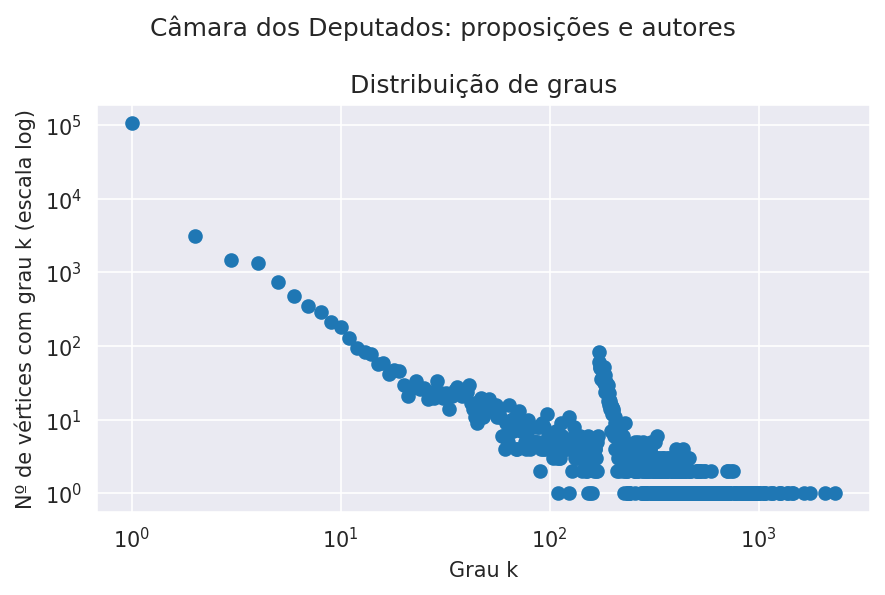

In [134]:
degree_dist = Counter(dict(G.degree).values())
xs = sorted(degree_dist.keys())
ys = [degree_dist[x] for x in xs]
plt.figure(figsize=(6,4))
plt.scatter(xs, ys)
plt.xlabel("Grau k")
plt.ylabel("Nº de vértices com grau k (escala log)")
plt.xscale("log")
plt.yscale("log")
plt.suptitle("Câmara dos Deputados: proposições e autores")
plt.title("Distribuição de graus")
plt.tight_layout()
plt.show()

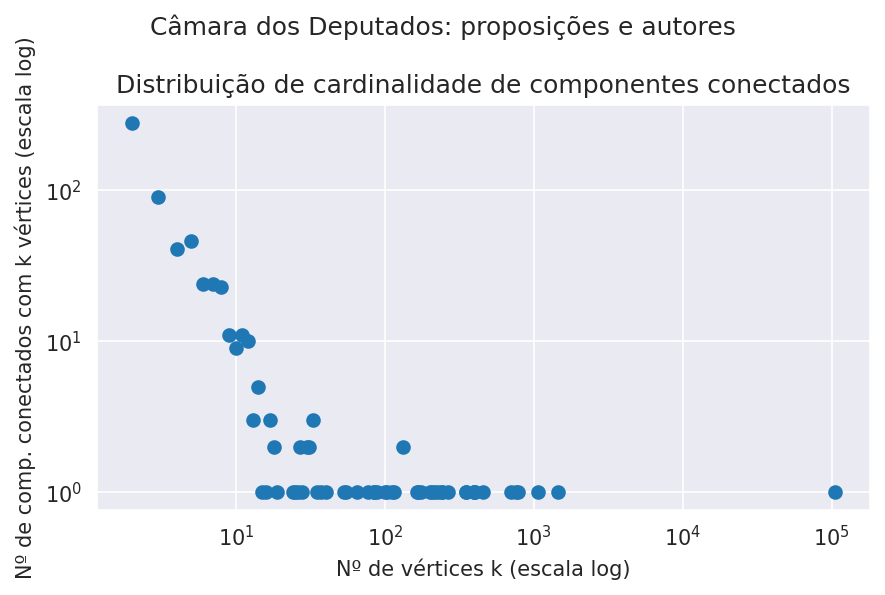

In [132]:
ccs = list(nx.connected_components(G))
cc_sizes = [len(cc) for cc in ccs]
cc_size_dist = Counter(cc_sizes)
xs = sorted(cc_size_dist.keys())
ys = [cc_size_dist[x] for x in xs]
plt.figure(figsize=(6,4))
plt.scatter(xs, ys)
plt.xlabel("Nº de vértices k (escala log)")
plt.ylabel("Nº de comp. conectados com k vértices (escala log)")
plt.xscale("log")
plt.yscale("log")
plt.suptitle("Câmara dos Deputados: proposições e autores")
plt.title("Distribuição de cardinalidade de componentes conectados")
plt.tight_layout()
plt.show()

In [135]:
V = G.number_of_nodes()
E = G.number_of_edges()
k = 2 * V / E
print(f"|V| = {V}")
print(f"|E| = {E}")
print(f"<k> = {k}")


|V| = 118089
|E| = 335656
<k> = 0.7036310985056129
